ML model for Formula One.

In [1]:
# 
# Import required libraries
#

import sys
import os
import datetime 
import tensorflow                                      as tf
import shutil                                          as shu
import warnings                                        as warn
import pandas                                          as pd
import matplotlib.pyplot                               as plt

from   pymongo                 import MongoClient
from   pprint                  import pprint
from   colorama                import Style            as st
from   colorama                import Fore             
from   colorama                import Back             as bk
from   sklearn.model_selection import train_test_split as tts
from   sklearn.preprocessing   import StandardScaler   as sts
from   sklearn.linear_model      import LinearRegression
from   tensorflow              import keras            as ker
from   keras.models            import Sequential       as seq
from   keras.layers            import Dense            as den
from   sklearn.metrics         import classification_report

warn.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#
# Environment Setup
#

start_time = datetime.datetime.now()
w, h       = shu.get_terminal_size()

def printSeparator():
    print(Fore.GREEN + '-' * w + Fore.WHITE)
    
def logStep(msg):
    l1 = len(msg)
    l2 = w - l1
    print(Fore.WHITE  + str(datetime.datetime.now()) +  " " + 
          Fore.YELLOW + msg + Fore.WHITE + "-" * l2  )
    sys.stdout.flush()

logStep("ENVIRONMENT PREPARATION")

def printDFinfo(name,dfName):
    printSeparator()
    print('Name: ',name)
    printSeparator()
    print(dfName.info())
    printSeparator()
    print(f'Row Count :{Fore.RED}')
    print(dfName.count(),Fore.WHITE)
    printSeparator()
    print(dfName.head())
    printSeparator()

def runtime_Diff(step_Number, step_Message1,base_SQL, cached_SQL):
  start_time          = datetime.datetime.now()
  logStep(step_Number + " - RUNTIME DIFFERENCE")
  time_difference     = base_SQL - cached_SQL
  logStep(F"{step_Number} - Time required for a non-cached Query : {base_SQL}")
  logStep(F"{step_Number} - Time required for a cached/part Query: {cached_SQL}")
  logStep(F"{step_Number} - Time difference                      : {time_difference}")
  logStep(step_Number + " - DONE")
  end_time            = datetime.datetime.now()
  step_elapsed_time   = end_time - start_time
  logStep(F"{step_Number} - ELAPSED TIME: {step_elapsed_time} seconds")
  return step_elapsed_time

print(F"Copyright                              : {sys.copyright}")
print(F"OS Platform                            : {sys.platform}")
print(F"OS Name                                : {os.name}")
print(F"OS HOME                                : {os.environ.get('HOME')}")
print(F"OS uName                               : {os.uname().sysname}")
print(F"OS NodeName                            : {os.uname().nodename}")
print(F"OS Release                             : {os.uname().release}")
print(F"OS Release Ver                         : {os.uname().version}")
print(F"OS Machine                             : {os.uname().machine}")
print(F"Process ID                             : {os.getpid()}")
print(F"Parent Process                         : {os.getppid()}")
print(F"OS User                                : {os.getlogin()}")
print(F"OS User ID                             : {os.getuid()}")
print(F"OS Group ID                            : {os.getgid()}")
print(F"OS Effective ID                        : {os.geteuid()}")
print(F"OS Effective GID                       : {os.getegid()}")
print(F"Current dir                            : {os.getcwd()}")
print(F"Python version                         : {sys.version}")
print(F"Version info                           : {sys.version_info}")
print(F"Python API Ver                         : {sys.api_version}")
print(F"Executable                             : {sys.executable}")
print(F"Spark UI                               : http://localhost:4040")
print(F"Spark submit                           : {sys.argv[0]}")
print(F"Hadoop Home                            : {os.environ.get('HADOOP_HOME')}")
print(F"Java Home                              : {os.environ.get('JAVA_HOME')}")
print(F"Current Working Directory              : {os.getcwd()}")

logStep("DONE");
end_time            = datetime.datetime.now()
step00_elapsed_time = end_time - start_time
logStep(F"ELAPSED TIME: {step00_elapsed_time} seconds")

2023-09-28 18:37:19.090180 ENVIRONMENT PREPARATION---------------------------------------------------------
Copyright                              : Copyright (c) 2001-2023 Python Software Foundation.
All Rights Reserved.

Copyright (c) 2000 BeOpen.com.
All Rights Reserved.

Copyright (c) 1995-2001 Corporation for National Research Initiatives.
All Rights Reserved.

Copyright (c) 1991-1995 Stichting Mathematisch Centrum, Amsterdam.
All Rights Reserved.
OS Platform                            : darwin
OS Name                                : posix
OS HOME                                : /Users/eneas
OS uName                               : Darwin
OS NodeName                            : MBPJES14M2.local
OS Release                             : 23.1.0
OS Release Ver                         : Darwin Kernel Version 23.1.0: Thu Sep 14 23:08:12 PDT 2023; root:xnu-10002.40.63.505.1~3/RELEASE_ARM64_T6020
OS Machine                             : arm64
Process ID                             : 23

In [3]:
logStep('Environment Preparation')

mongo = MongoClient(port=27017)
print(mongo.list_database_names())
db    = mongo['F1']
print(db.list_collection_names())
Results = db['Results']
logStep('Environment Preparation Completed')

2023-09-28 18:37:19.099836 Environment Preparation---------------------------------------------------------
['F1', 'admin', 'config', 'local', 'met', 'uk_food']
['Drivers', 'Teams', 'Results']
2023-09-28 18:37:19.109565 Environment Preparation Completed-----------------------------------------------


In [4]:
# Check that the new restaurant was inserted
# Filter results by name
logStep('Model Preparation')

query  = ({"Position" : {"$gt": 0}})
fields = {'Position'  : 1,
          'Driver': 1,
          'Starting Grid': 1,
          'Laps': 1,
          'Time/Retired': 1,
          'Points': 1}
results = Results.find(query,fields)
results_df = pd.DataFrame(list(results))
results_df = results_df.drop(columns=['_id'])
print(results_df.head())
logStep('Model Preparation Completed')

2023-09-28 18:37:19.114171 Model Preparation---------------------------------------------------------------
   Position            Driver  Starting Grid  Laps Time/Retired  Points
0         1  Sebastian Vettel            3.0    58      29:33.3    25.0
1         2    Lewis Hamilton            1.0    58        5.036    18.0
2         3  Kimi RaikkAAPnen            2.0    58        6.309    15.0
3         4  Daniel Ricciardo            8.0    58        7.069    12.0
4         5   Fernando Alonso           10.0    58       27.886    10.0
2023-09-28 18:37:19.129505 Model Preparation Completed-----------------------------------------------------


In [5]:
printDFinfo('results_df',results_df)

--------------------------------------------------------------------------------
Name:  results_df
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Position       1030 non-null   int64  
 1   Driver         1030 non-null   object 
 2   Starting Grid  1029 non-null   float64
 3   Laps           1030 non-null   int64  
 4   Time/Retired   1030 non-null   object 
 5   Points         1030 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 48.4+ KB
None
--------------------------------------------------------------------------------
Row Count :
Position         1030
Driver           1030
Starting Grid    1029
Laps             1030
Time/Retired     1030
Points           1030
dtype: int64 
-------------------------------------------------------

In [6]:
#
# Log the processing progress
#

logStep('Model Preparation')
    
# 
# Determine the number of unique values in each column.
#

printSeparator()
print('results_df.nunique()')
printSeparator()
print(results_df.nunique())
printSeparator()

logStep('Model Preparation')
    
# 

2023-09-28 18:37:19.171665 Model Preparation---------------------------------------------------------------
--------------------------------------------------------------------------------
results_df.nunique()
--------------------------------------------------------------------------------
Position          10
Driver            31
Starting Grid     20
Laps              30
Time/Retired     869
Points            22
dtype: int64
--------------------------------------------------------------------------------
2023-09-28 18:37:19.176092 Model Preparation---------------------------------------------------------------


In [7]:
#
# Log the processing progress
#

logStep('For columns that have more than 10 unique values, determine the number of data points for each unique value.')
    

for column_Name in results_df.columns:
    if results_df[column_Name].nunique() > 10:
        print('Column Name', column_Name)
        printSeparator()
        print(results_df[column_Name].value_counts())
        printSeparator()


logStep('determined the number of data points for each unique value.')
  

2023-09-28 18:37:19.185446 For columns that have more than 10 unique values, determine the number of data points for each unique value.
Column Name Driver
--------------------------------------------------------------------------------
Driver
Lewis Hamilton        96
Max Verstappen        87
Valtteri Bottas       76
Charles Leclerc       75
Carlos Sainz          74
Sergio Perez          71
Lando Norris          61
Sebastian Vettel      60
Daniel Ricciardo      55
Pierre Gasly          50
Esteban Ocon          50
Fernando Alonso       38
Lance Stroll          35
Kimi RaikkAAPnen      32
Alexander Albon       28
George Russell        25
Nico Hulkenberg       23
Kevin Magnussen       22
Daniil Kvyat          17
Romain Grosjean       11
Yuki Tsunoda          11
Antonio Giovinazzi     9
Marcus Ericsson        6
Stoffel Vandoorne      4
Guanyu Zhou            3
Brendon Hartley        3
Nicholas Latifi        3
Mick Schumacher        2
Sergey Sirotkin        1
Robert Kubica          1
Nyck De

In [8]:
results_df.insert(0,'Champion',0)
print(results_df)

      Champion  Position            Driver  Starting Grid  Laps Time/Retired  \
0            0         1  Sebastian Vettel            3.0    58      29:33.3   
1            0         2    Lewis Hamilton            1.0    58        5.036   
2            0         3  Kimi RaikkAAPnen            2.0    58        6.309   
3            0         4  Daniel Ricciardo            8.0    58        7.069   
4            0         5   Fernando Alonso           10.0    58       27.886   
...        ...       ...               ...            ...   ...          ...   
1025         0         6      Lando Norris            7.0    58       56.234   
1026         0         7      Esteban Ocon            8.0    58        57.24   
1027         0         8      Lance Stroll           14.0    58       76.931   
1028         0         9  Daniel Ricciardo           13.0    58       83.268   
1029         0        10  Sebastian Vettel            9.0    58       83.898   

      Points  
0       25.0  
1       1

In [9]:
#
# Log the processing progress
#

logStep('Use  pd.get_dummies()  to encode categorical variables.')
#
# Convert categorical data to numeric with `pd.get_dummies`
#

results_df_numeric = pd.get_dummies(results_df)
printDFinfo('results_df_numeric',results_df_numeric)

2023-09-28 18:37:19.212131 Use  pd.get_dummies()  to encode categorical variables.-------------------------
--------------------------------------------------------------------------------
Name:  results_df_numeric
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Columns: 905 entries, Champion to Time/Retired_59:47.5
dtypes: bool(900), float64(2), int64(3)
memory usage: 945.6 KB
None
--------------------------------------------------------------------------------
Row Count :
Champion                1030
Position                1030
Starting Grid           1029
Laps                    1030
Points                  1030
                        ... 
Time/Retired_51:11.6    1030
Time/Retired_56:30.3    1030
Time/Retired_58:23.3    1030
Time/Retired_58:33.7    1030
Time/Retired_59:47.5    1030
Length: 905, dtype: int64 
--------------------------------------------------------------------

In [10]:
#
# Log the processing progress
#

logStep('Preprocess the Data')

# 
# Split our preprocessed data into our features and target arrays
#
results_df_numeric.dropna()
X = results_df_numeric.drop(['Champion'], axis=1)
y = results_df_numeric['Champion']

#
# Split the preprocessed data into a training and testing dataset
#

X_train, X_test, y_train, y_test = tts(X, y, random_state=58)

print('X_train.shape')
print(X_train.shape)
printSeparator()
print('X_test.shape')
print(X_test.shape)
printSeparator()
print('y_train.shape')
print(y_train.shape)
printSeparator()
print('y_test.shape')
print(y_test.shape)
printSeparator()

2023-09-28 18:37:19.325610 Preprocess the Data-------------------------------------------------------------
X_train.shape
(772, 904)
--------------------------------------------------------------------------------
X_test.shape
(258, 904)
--------------------------------------------------------------------------------
y_train.shape
(772,)
--------------------------------------------------------------------------------
y_test.shape
(258,)
--------------------------------------------------------------------------------


In [11]:
#
# Log the processing progress
#

logStep('Scale the training and testing features datasets')

#
# Create a Standard Scaler instance
# Fit the Standard Scaler
# Scale the data
#

scaler         = sts()
X_scaler       = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled  = X_scaler.transform(X_test)

#
# Log the processing progress
#

print('X_train_scaled.shape')
print(X_train_scaled.shape)
printSeparator()
print('X_test_scaled.shape')
print(X_test_scaled.shape)
printSeparator()

2023-09-28 18:37:19.334436 Scale the training and testing features datasets--------------------------------
X_train_scaled.shape
(772, 904)
--------------------------------------------------------------------------------
X_test_scaled.shape
(258, 904)
--------------------------------------------------------------------------------


In [12]:
#
# Log the processing progress
#

logStep('Define the model parameters')

# 
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
#

number_input_features = len(X_train_scaled[0]) # type: ignore
hidden_nodes_layer1   = 12
hidden_nodes_layer2   = 12

nn_model = seq()

#
# First hidden layer
#

nn_model.add(den(units=hidden_nodes_layer1,input_dim=number_input_features, activation="tanh"))

#
# Second hidden layer
#

nn_model.add(den(units=hidden_nodes_layer2, activation="tanh"))

#
# Output layer
#

nn_model.add(den(units=1, activation="tanh"))

#
# Check the structure of the model
#

nn_model.summary()
printSeparator()
#
# Log the processing progress
#

logStep('10 - Compile the model')

# 
# Compile the model
#

nn_model.compile(loss      = 'binary_crossentropy', 
                 optimizer = 'adam', 
                 metrics   = ['accuracy'])
print('Model compiled')
printSeparator()

#
# Log the processing progress
#

logStep('Train the model parameters')
# 
# Train the model
#

print('Model Training')
printSeparator()

fit_model = nn_model.fit(X_train_scaled,y_train,epochs=50)

printSeparator()
print('Model Training Complete')
printSeparator()

2023-09-28 18:37:19.359398 Define the model parameters-----------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                10860     
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 11,029
Trainable params: 11,029
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------------------------------------
2023-09-28 18:37:19.412921 10 - Compile the model----------------------------------------------------------
Model compiled
----

2023-09-28 18:37:19.454199: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


25/25 [==============================] - 0s 797us/step - loss: 0.3611 - accuracy: 0.7889
Epoch 2/50
25/25 [==============================] - 0s 703us/step - loss: 0.1156 - accuracy: 0.9521
Epoch 3/50
25/25 [==============================] - 0s 688us/step - loss: 0.0414 - accuracy: 0.9870
Epoch 4/50
25/25 [==============================] - 0s 669us/step - loss: 0.0156 - accuracy: 0.9974
Epoch 5/50
25/25 [==============================] - 0s 616us/step - loss: 0.0059 - accuracy: 0.9987
Epoch 6/50
25/25 [==============================] - 0s 619us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 7/50
25/25 [==============================] - 0s 657us/step - loss: 9.6249e-04 - accuracy: 1.0000
Epoch 8/50
25/25 [==============================] - 0s 700us/step - loss: 2.5914e-04 - accuracy: 1.0000
Epoch 9/50
25/25 [==============================] - 0s 609us/step - loss: 1.7380e-04 - accuracy: 1.0000
Epoch 10/50
25/25 [==============================] - 0s 606us/step - loss: 6.7378e-05 - accuracy: 1

2023-09-28 18:37:20.600680 Evaluate the model parameters---------------------------------------------------
9/9 [==============================] - 0s 634us/step - loss: nan - accuracy: 1.0000 
Loss: nan, Accuracy: 1.00
Accuracy is 100.00%, greater than or equal to 75%
Model is optimized


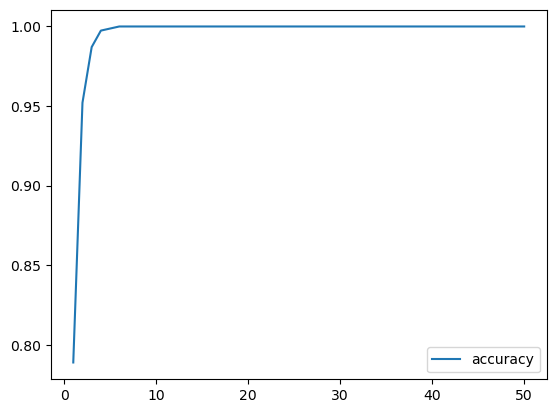

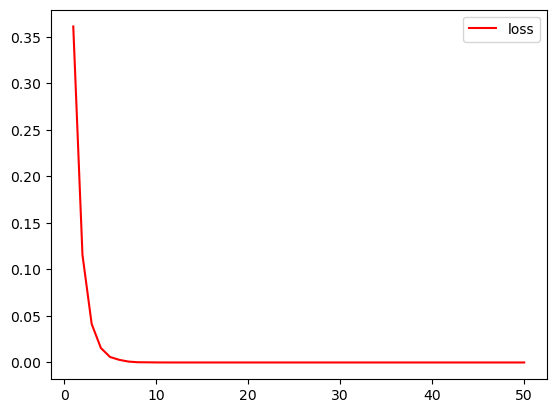

2023-09-28 18:37:20.818188 13 - Export the model to a HDF5 file--------------------------------------------
--------------------------------------------------------------------------------
Model saved to file :  Output/F1_model.h5
--------------------------------------------------------------------------------
End of processing


In [13]:
#
# Log the processing progress
#

logStep('Evaluate the model parameters')
# 
# Evaluate the model using the test data
#

skip_optimization = False
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test)
print(f"Loss: {model_loss:2.2f}, Accuracy: {model_accuracy:2.2f}")
accuracy = model_accuracy * 100
if (accuracy < 75):   
    print(F'Accuracy is {accuracy:2.2f}%, less than 75%')
    print("More optimization is required")
else:
    print(F'Accuracy is {accuracy:2.2f}%, greater than or equal to 75%')
    print("Model is optimized")
    history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
    history_df.plot(y="accuracy")
    plt.show()
    history_df.plot(y="loss",color='red')
    plt.show()
    #
    # Log the processing progress
    #
    logStep('13 - Export the model to a HDF5 file')
    # 
    # Export our model to HDF5 file
    #
    filename = 'Output/F1_model.h5'
    #
    # Save the model to a HDF5 file
    #

    nn_model.save(filename)
    printSeparator()
    print('Model saved to file : ',filename)
    printSeparator()
    print('End of processing')
    skip_optimization = True

In [14]:
#
# Log the processing progress
#
if skip_optimization == False:
  logStep('Attempt 2 - Add more neurons to a hidden layer')
  number_input_features = len(X_train_scaled[0]) # type: ignore
  print('Number of input features : ',number_input_features)
  for nodes in range(14, 140, 2):
    printSeparator()
    print('Number of hidden nodes   : ',nodes)
    hidden_nodes_layer1   = nodes
    hidden_nodes_layer2   = nodes
    hidden_nodes_layer3   = nodes
    hidden_nodes_layer4   = nodes
    hidden_nodes_layer5   = nodes
    nn_model2             = seq(name=f"Optimized_Model_{nodes}")
    nn_model2.add(den(units=hidden_nodes_layer1,input_dim=number_input_features, activation="tanh"))
    nn_model2.add(den(units=hidden_nodes_layer2, activation="tanh"))
    nn_model2.add(den(units=hidden_nodes_layer3, activation="tanh"))
    nn_model2.add(den(units=hidden_nodes_layer4, activation="tanh"))
    nn_model2.add(den(units=hidden_nodes_layer5, activation="tanh"))
    nn_model2.add(den(units=1,activation="tanh"))
    nn_model2.summary()
    printSeparator()
    print('Compile the model')
    nn_model2.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics   = ['accuracy'])
    print('Model compiled')
    printSeparator()
    print('Fit the model')
    fit_model2 = nn_model2.fit(X_train_scaled,y_train,epochs=50)
    print('Model fit')
    printSeparator()
    print('Evaluate the model')
    model_loss2, model_accuracy2 = nn_model2.evaluate(X_test_scaled,y_test)
    print(f"Loss: {model_loss2:2.2f}, Accuracy: {model_accuracy2:2.2f}")
    accuracy2 = model_accuracy2 * 100
    if (accuracy2 < 75):   
      print(F'Accuracy is {accuracy2:2.2f}, less than 75%')
      print("More optimization is required")
    else:
      print(F'Accuracy is {accuracy2:2.2f}, greater than or equal to 75%')
      print("Model is optimized")
      logStep('15 - Export the model to an HDF5 file')
      filename = 'Output/F1_model.h5'
      nn_model.save(filename)
      printSeparator()
      print('Model saved to file : ',filename)
      printSeparator()
      print('End of processing')
      break

In [20]:
model = tf.keras.models.load_model(filename)
predictions = model.predict(X_test_scaled)
target_names = results_df['Driver']
print(target_names.head(10))
# Print the predictions
pprint(predictions)

9/9 [==============================] - 0s 565us/step
0     Sebastian Vettel
1       Lewis Hamilton
2     Kimi RaikkAAPnen
3     Daniel Ricciardo
4      Fernando Alonso
5       Max Verstappen
6      Nico Hulkenberg
7      Valtteri Bottas
8    Stoffel Vandoorne
9         Carlos Sainz
Name: Driver, dtype: object
array([[-0.8398599 ],
       [-0.8532799 ],
       [-0.8165465 ],
       [-0.7972595 ],
       [-0.8733853 ],
       [-0.8245624 ],
       [-0.83117497],
       [-0.8538377 ],
       [-0.84424657],
       [-0.8349356 ],
       [-0.85222834],
       [-0.8248733 ],
       [-0.83444846],
       [-0.8506904 ],
       [-0.85059   ],
       [-0.8318422 ],
       [-0.8204958 ],
       [-0.8620889 ],
       [-0.8171031 ],
       [-0.8011705 ],
       [-0.8421145 ],
       [-0.861587  ],
       [-0.78562266],
       [-0.80155224],
       [-0.85023636],
       [-0.85143465],
       [-0.8523052 ],
       [-0.8291426 ],
       [-0.8591754 ],
       [-0.8719231 ],
       [-0.8429978 ],
       

In [16]:
mongo.close()